In [2]:
import numpy as np
import cv2
import torch
import json
import matplotlib.pyplot as plt

# Using YOLO/Detectron2 to segment

## Using Detectron2

In [3]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# python -m pip install git+https://github.com/facebookresearch/detectron2.git

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

fatal: destination path 'detectron2' already exists and is not an empty directory.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [34]:
import pycocotools.mask as mask_util


def binary_mask_to_polygons(mask):
    contours, hierarchy = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) >= 3:  # valid polygon
            polygon = contour.flatten().tolist()
            reshaped_polygon = [[polygon[i], polygon[i+1]] for i in range(0, len(polygon), 2)]
            polygons.append(reshaped_polygon)
    return polygons

def save_json(file_name, outputs, output_folder):
    instances = outputs["instances"].to("cpu")
    pred_classes = instances.pred_classes.tolist()
    pred_boxes = instances.pred_boxes.tensor.tolist()
    pred_scores = instances.scores.tolist()
    pred_masks = instances.pred_masks.numpy()
    pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]

    detection_results = []
    for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
        instance_result = {
            "class": cls,
            "box": box,
            "score": score,
            "mask": [{"polygon": polygon} for polygon in polygons]
        }
        detection_results.append(instance_result)

    result_dict = {
        "file_name": file_name,
        "instances": detection_results
    }

    json_output_file_path = os.path.join(output_folder, f"{file_name.split('.')[0]}.json")
    
    os.makedirs(os.path.dirname(json_output_file_path), exist_ok=True)

    with open(json_output_file_path, 'w') as json_file:
        json.dump(result_dict, json_file, indent=4)


def save_test_image(image, file_name, output_folder):
    output_image_path = os.path.join(output_folder, f"test_{file_name}")
    cv2.imwrite(output_image_path, image)

def visualize_single_image(image_path, cfg, predictor, output_folder):
    image = cv2.imread(image_path)
    outputs = predictor(image)
    
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

    plt.imshow(out_img)
    plt.show()
    
    # Save visualized image
    file_name = os.path.basename(image_path)
    save_test_image(out_img, file_name, output_folder)
    
    # Save JSON
    save_json(f"test_{file_name}", outputs, output_folder)

def process_folder(input_folder, output_folder, cfg, predictor):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            im = cv2.imread(file_path)  # Read image in BGR format
            if im is None:
                continue
            im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            outputs = predictor(im_rgb)  # Get predictions from the model

            v = Visualizer(im_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

            test_name = f"test_{file_name}"
            save_test_image(out_img, file_name, output_folder)

            # Save JSON
            save_json(test_name, outputs, output_folder)


Loading config /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/22 19:31:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...
[Checkpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...


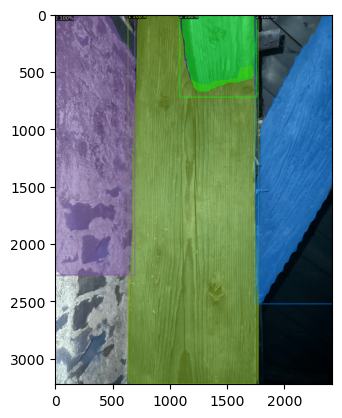

zsh:1: command not found: Folder


In [37]:
cfg = get_cfg()
cfg.merge_from_file("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/config.yaml")
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth"


predictor = DefaultPredictor(cfg)

# ! Single test
image_path = r"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/IMG_0002.jpeg"
output_folder = f"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output"
visualize_single_image(image_path, cfg, predictor, output_folder)

! Folder test
# input_folder = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/2024_07_09_09_57_14'
# output_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output'
# process_folder(input_folder, output_folder, cfg, predictor)

# Read image and segmented area

In [31]:
# ! Rectangle
# image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_2_0070_jpeg.rf.f6b63d3d61757bb631819d5e228ffe1f.jpg")
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_2_0070_jpeg.rf.f6b63d3d61757bb631819d5e228ffe1f.jpg")


# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_2_0070_jpeg.json") as f:
#     data = json.load(f)

# ! Quadrilateral

# image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg")
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg")

# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_14_0013_jpeg.json") as f:
#     data = json.load(f)

# ! Not Quadrilateral

# image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/IMG_0003.jpeg")
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_IMG_0003.jpeg")

# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_IMG_0003.json") as f:
#     data = json.load(f)

! test

image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/IMG_0003.jpeg")
image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_IMG_0003.jpeg")

with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output/test_IMG_0003.json") as f:
    data = json.load(f)

seg_output = data
class_map = {1: "other", 2: "main_beam"}

print(seg_output)


{'file_name': 'test_IMG_0003.jpeg', 'instances': [{'class': 2, 'box': [2122.230712890625, 0.0, 3019.274169921875, 1690.396728515625], 'score': 0.999691367149353, 'mask': [{'polygon': [[2226, 0], [2225, 1], [2202, 1], [2201, 2], [2200, 2], [2199, 3], [2198, 3], [2195, 6], [2194, 6], [2183, 17], [2183, 18], [2181, 20], [2181, 21], [2179, 23], [2179, 24], [2178, 25], [2178, 26], [2177, 27], [2177, 28], [2176, 29], [2176, 32], [2175, 33], [2175, 39], [2174, 40], [2174, 46], [2173, 47], [2173, 52], [2172, 53], [2172, 58], [2171, 59], [2171, 63], [2170, 64], [2170, 69], [2169, 70], [2169, 75], [2168, 76], [2168, 81], [2167, 82], [2167, 88], [2166, 89], [2166, 103], [2165, 104], [2165, 122], [2164, 123], [2164, 143], [2163, 144], [2163, 166], [2162, 167], [2162, 193], [2161, 194], [2161, 215], [2160, 216], [2160, 229], [2159, 230], [2159, 243], [2158, 244], [2158, 259], [2157, 260], [2157, 294], [2156, 295], [2156, 350], [2155, 351], [2155, 390], [2154, 391], [2154, 484], [2153, 485], [2153, 

# Select main area

## select max area

In [4]:
#FUNCTION: Select the mask with the largest area using Shoelace formula

def polygon_area(polygon):
    polygon = np.array(polygon)
    x = polygon[:, 0]
    y = polygon[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    
max_area = 0
max_area_index = -1

for i, instance in enumerate(seg_output['instances']):
    polygons = instance['mask']
    for j, polygon_data in enumerate(polygons):
        polygon = polygon_data['polygon']
        area = polygon_area(polygon)
        print(f"Mask_{i}_{j} area: {area}")
        if area > max_area:
            max_area = area
            max_area_index = f"Mask_{i}_{j}"
            max_polygon = polygon

print(f"Largest mask index: {max_area_index}, area: {max_area}")

largest_polygon = max_polygon
print(largest_polygon)

Mask_0_0 area: 895980.0
Mask_1_0 area: 5067747.0
Mask_2_0 area: 3166417.0
Largest mask index: Mask_1_0, area: 5067747.0
[[847, 0], [846, 1], [833, 1], [832, 2], [820, 2], [819, 3], [807, 3], [806, 4], [803, 4], [803, 5], [801, 7], [801, 8], [800, 9], [800, 10], [799, 11], [799, 12], [798, 13], [798, 14], [797, 15], [797, 16], [796, 17], [796, 18], [795, 19], [795, 20], [794, 21], [794, 23], [793, 24], [793, 25], [792, 26], [792, 28], [791, 29], [791, 31], [790, 32], [790, 34], [789, 35], [789, 37], [788, 38], [788, 41], [787, 42], [787, 45], [786, 46], [786, 48], [785, 49], [785, 53], [784, 54], [784, 57], [783, 58], [783, 62], [782, 63], [782, 67], [781, 68], [781, 114], [780, 115], [780, 1306], [781, 1307], [781, 1406], [782, 1407], [782, 1453], [783, 1454], [783, 1496], [784, 1497], [784, 1532], [785, 1533], [785, 1562], [786, 1563], [786, 1590], [787, 1591], [787, 1617], [788, 1618], [788, 1642], [789, 1643], [789, 1663], [790, 1664], [790, 1680], [791, 1681], [791, 1695], [792, 16

## Plot original polygon

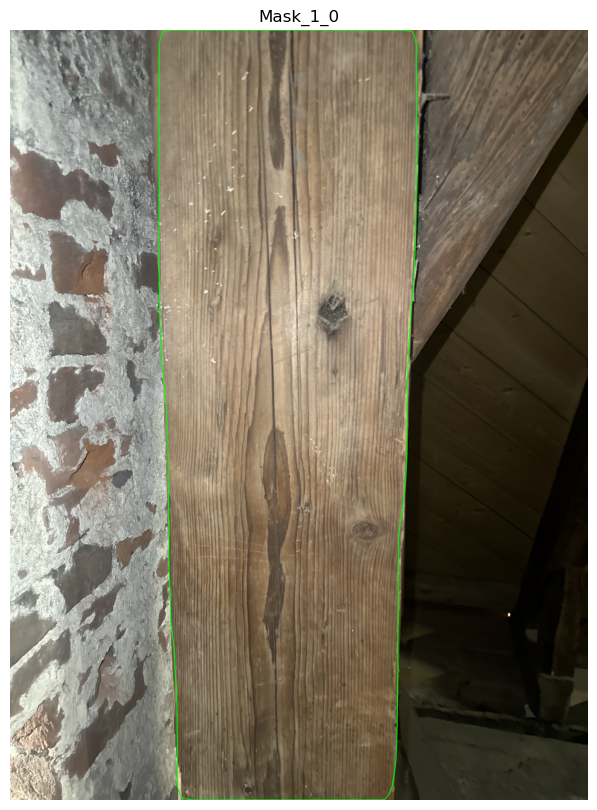

In [5]:
def draw_polygon_on_image(image, polygon):
    pts = np.array(polygon, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=3)
    return image

image_with_polygon = draw_polygon_on_image(image_org.copy(), largest_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))
plt.title(max_area_index)
plt.axis('off')
plt.show()

# plt.imsave("image_with_largest_polygon.jpg", cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))


# Abstract complex polygon from the main area to simple polygon

In [6]:
def draw_simple_polygon(image, simplified_polygon):
    pts = np.array(simplified_polygon, np.int32)
    if pts.shape[-1] == 1:
        pts = pts.reshape((-1, 2))
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=3) 
    return image

## Simplify polygon using **Douglas-Peucker**

Simplified polygon using Douglas-Peucker algorithm:
[[[ 321    0]]

 [[ 276 1011]]

 [[ 557 1022]]

 [[ 541   15]]]


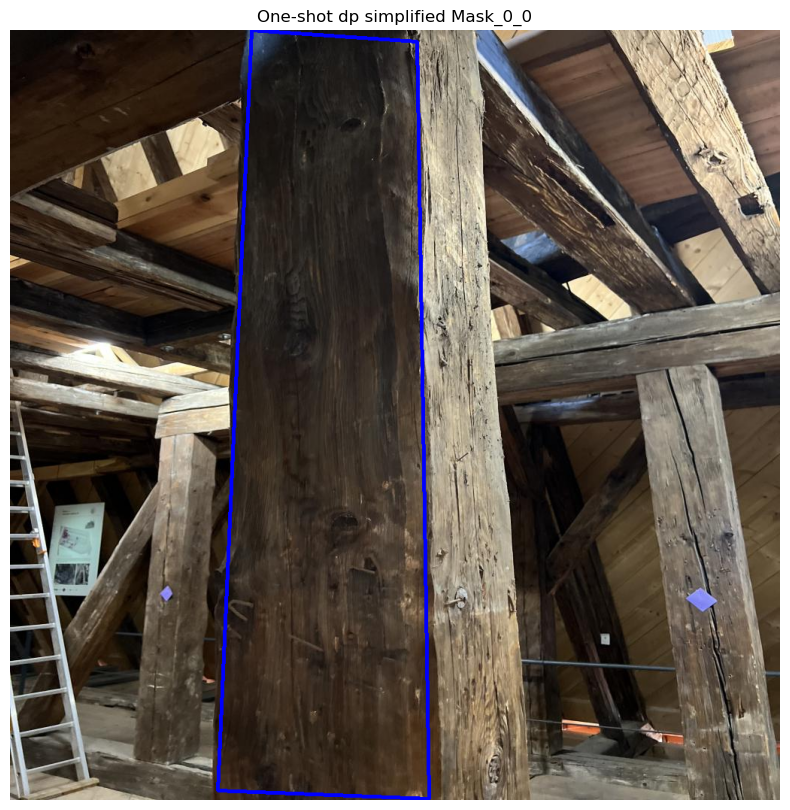

In [51]:
# FUNCTION: Simplify the polygon using Douglas-Peucker algorithm

def dp_simplify(polygon, epsilon_factor=0.006):
    contour = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

dp_simplified_polygon = dp_simplify(largest_polygon)

print("Simplified polygon using Douglas-Peucker algorithm:")
print(dp_simplified_polygon)

image_with_dp_polygon = draw_simple_polygon(image_org.copy(), dp_simplified_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_dp_polygon, cv2.COLOR_BGR2RGB))
plt.title(f"One-shot dp simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_with_dp_polygon.jpg", cv2.cvtColor(image_with_dp_polygon, cv2.COLOR_BGR2RGB))



## Simplify polygon using **Visvalingam–Whyatt**

Simplified polygon using Visvalingam–Whyatt algorithm:
[[8.470e+02 0.000e+00]
 [8.460e+02 1.000e+00]
 [8.330e+02 1.000e+00]
 ...
 [2.066e+03 1.000e+00]
 [2.057e+03 1.000e+00]
 [2.056e+03 0.000e+00]]


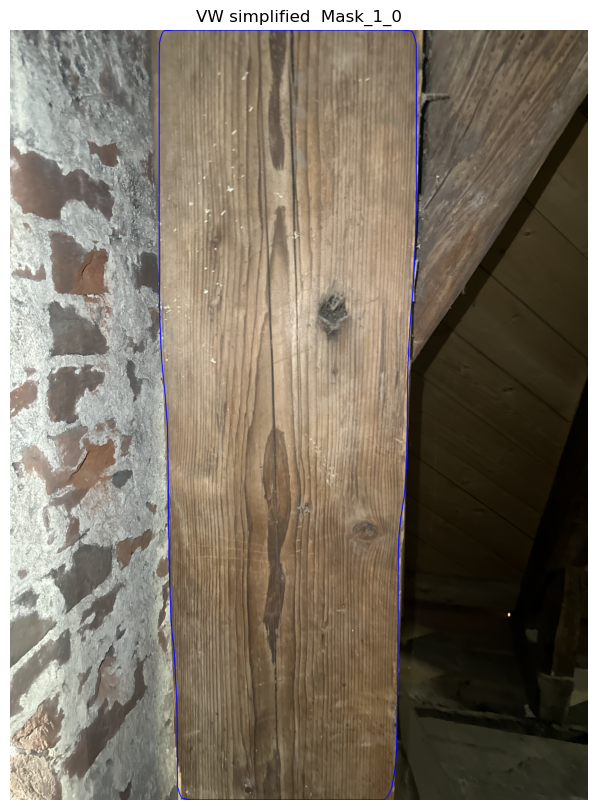

In [7]:
# FUNCTION: Simplified polygon using Visvalingam–Whyatt algorithm

def vw_simplify(polygon, threshold=0.5):
    def area_of_triangle(p1, p2, p3):
        return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))
    
    points = np.array(polygon, dtype=np.float32)
    is_removed = np.zeros(points.shape[0], dtype=bool)
    areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
    
    while len(areas) > 0 and np.min(areas) < threshold:
        min_index = np.argmin(areas) + 1
        is_removed[min_index] = True
        points = points[~is_removed]
        print(f"Removed point at index {min_index}, remaining points: {len(points)}")
        if len(points) < 3:
            break
        areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
        print(f"Recomputed areas: {areas}")
    return points

vw_simplified_polygon = vw_simplify(largest_polygon)

print("Simplified polygon using Visvalingam–Whyatt algorithm:")
print(vw_simplified_polygon)

image_with_vw_polygon = draw_simple_polygon(image_org.copy(), vw_simplified_polygon)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_vw_polygon, cv2.COLOR_BGR2RGB))
plt.title(f"VW simplified  {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_with_vw_polygon.jpg", cv2.cvtColor(image_with_vw_polygon, cv2.COLOR_BGR2RGB))


### Plot simplify polygon

## Simplify polygon using **convex_hull**

[[[2056    0]]

 [[2096    4]]

 [[2102    5]]

 [[2103    6]]

 [[2105    9]]

 [[2110   19]]

 [[2113   26]]

 [[2117   38]]

 [[2119   45]]

 [[2122   57]]

 [[2124   67]]

 [[2125   80]]

 [[2126  198]]

 [[2126  659]]

 [[2125  860]]

 [[2124  981]]

 [[2123 1048]]

 [[2122 1093]]

 [[2021 3779]]

 [[2020 3805]]

 [[2019 3821]]

 [[2018 3831]]

 [[2016 3849]]

 [[2013 3873]]

 [[2011 3887]]

 [[2009 3900]]

 [[2000 3955]]

 [[1999 3961]]

 [[1994 3976]]

 [[1992 3981]]

 [[1989 3988]]

 [[1983 4000]]

 [[1980 4005]]

 [[1976 4011]]

 [[1973 4015]]

 [[1969 4020]]

 [[1959 4030]]

 [[1945 4031]]

 [[ 947 4031]]

 [[ 934 4029]]

 [[ 917 4026]]

 [[ 901 4023]]

 [[ 899 4022]]

 [[ 896 4017]]

 [[ 889 4003]]

 [[ 887 3998]]

 [[ 884 3990]]

 [[ 883 3987]]

 [[ 881 3980]]

 [[ 877 3964]]

 [[ 876 3959]]

 [[ 841 3083]]

 [[ 786 1590]]

 [[ 785 1562]]

 [[ 784 1532]]

 [[ 783 1496]]

 [[ 782 1453]]

 [[ 781 1406]]

 [[ 780 1306]]

 [[ 780  115]]

 [[ 781   68]]

 [[ 783   58]]

 [[ 785 

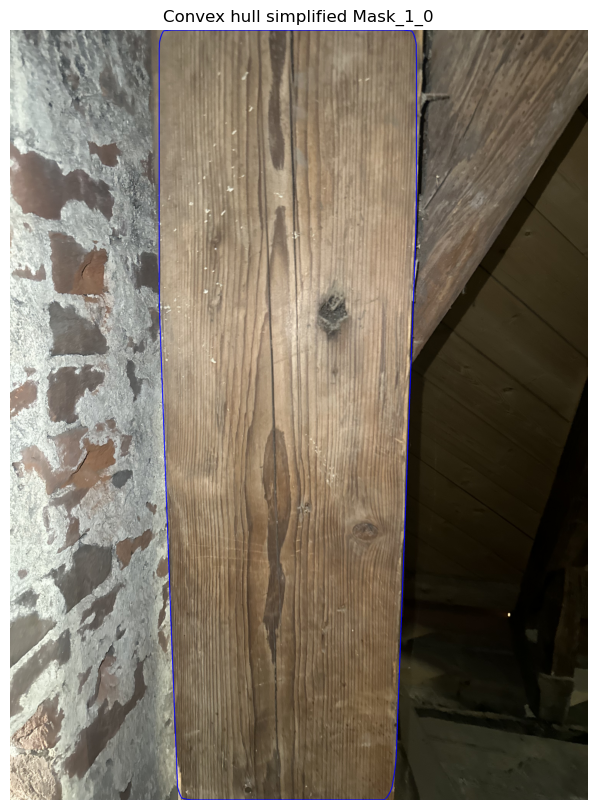

In [8]:
#FUNCTION: convex_hull

def ch_simplify(polygon):
    points = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    hull = cv2.convexHull(points)
    return hull

# simplified_polygon = ch_simplify(dp_simplified_polygon)
simplified_polygon = ch_simplify(vw_simplified_polygon)

print(simplified_polygon)

image_after_ch = draw_simple_polygon(image_org.copy(), simplified_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))
plt.title(f"Convex hull simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_after_ch.jpg", cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))



# Reshape the simple polygon to parallel pairs/correct perspective

## Find the outer quadrilateral of the polygon using Douglas-Peucker


Best outer quadrilateral: [[[2102    5]]

 [[1999 3961]]

 [[ 901 4023]]

 [[ 788   38]]]


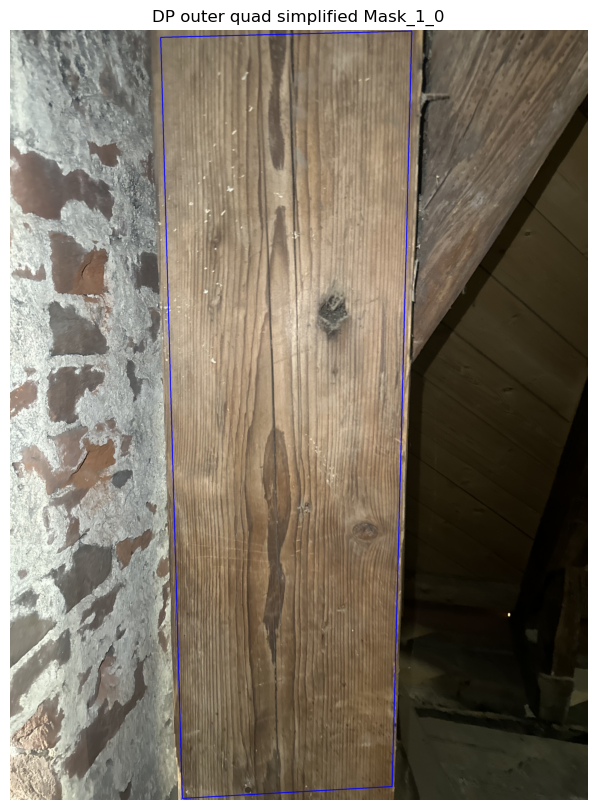

In [10]:
# FUNCTION: Simplify the polygon using Douglas-Peucker algorithm

def dp_simplify(polygon, epsilon_factor=0.006):
    contour = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

optimal_quad_pts = dp_simplify(simplified_polygon, epsilon_factor=0.03)

print("Best outer quadrilateral:", optimal_quad_pts)

optimal_quad_pts = ch_simplify(optimal_quad_pts)

image_outer_quad = draw_simple_polygon(image_org.copy(), optimal_quad_pts)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_outer_quad, cv2.COLOR_BGR2RGB))
plt.title(f"DP outer quad simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_after_ch.jpg", cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))

# Perspective correction

## Loop calculation

In [19]:
def preprocess_vertices(vertices):
    points = [(v[0][0], v[0][1]) for v in vertices]

    center = np.mean(points, axis=0)
    sorted_points = sorted(points, key=lambda p: (np.arctan2(p[1] - center[1], p[0] - center[0])))
    # print(sorted_points)
    return sorted_points

def polygon_centroid(vertices):
    n = len(vertices)
    if n < 3:
        raise ValueError("A polygon must have at least three vertices")
    
    A = 0
    for i in range(n):
        x0, y0 = vertices[i]
        x1, y1 = vertices[(i + 1) % n]
        A += x0 * y1 - x1 * y0
    A /= 2
    
    Cx = 0
    Cy = 0
    for i in range(n):
        x0, y0 = vertices[i]
        x1, y1 = vertices[(i + 1) % n]
        common_factor = (x0 * y1 - x1 * y0)
        Cx += (x0 + x1) * common_factor
        Cy += (y0 + y1) * common_factor
    Cx /= (6 * A)
    Cy /= (6 * A)
    
    print("centroid success")
    return Cx, Cy

def distance(pt1, pt2):
    print("distance success")
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def get_vertices_from_quad(vertices, centroid, image_shape):
    dists = [
        distance(vertices[0], vertices[1]),
        distance(vertices[1], vertices[2]),
        distance(vertices[2], vertices[3]),
        distance(vertices[3], vertices[0])
    ]
    print("dists success")

    avg_length = [dists[0] + dists[2], dists[1] + dists[3]]
    print("avg_length success")

    rect = np.array([
        [centroid[0] - avg_length[0] / 2, centroid[1] - avg_length[1] / 2],
        [centroid[0] + avg_length[0] / 2, centroid[1] - avg_length[1] / 2],
        [centroid[0] + avg_length[0] / 2, centroid[1] + avg_length[1] / 2],
        [centroid[0] - avg_length[0] / 2, centroid[1] + avg_length[1] / 2]
    ], dtype="float32")
    
    print("rect array success")
    
    # Adjust rect to fit within image bounds
    width, height = image_shape[1], image_shape[0]
    scale_factor = 1.0
    while True:
        min_x = np.min(rect[:, 0])
        min_y = np.min(rect[:, 1])
        max_x = np.max(rect[:, 0])
        max_y = np.max(rect[:, 1])
        
        if min_x >= 0 and min_y >= 0 and max_x < width and max_y < height:
            break
        
        scale_factor *= 0.80
        rect = np.array([
            [centroid[0] - (avg_length[0] / 2) * scale_factor, centroid[1] - (avg_length[1] / 2) * scale_factor],
            [centroid[0] + (avg_length[0] / 2) * scale_factor, centroid[1] - (avg_length[1] / 2) * scale_factor],
            [centroid[0] + (avg_length[0] / 2) * scale_factor, centroid[1] + (avg_length[1] / 2) * scale_factor],
            [centroid[0] - (avg_length[0] / 2) * scale_factor, centroid[1] + (avg_length[1] / 2) * scale_factor]
        ], dtype="float32")
    
    print("rect success")
    return rect

In [20]:
vertices = preprocess_vertices(optimal_quad_pts)

centroid = polygon_centroid(vertices)
print(f'centroid: ', centroid)

rect = get_vertices_from_quad(vertices, centroid, image_shape=image_org.shape)
print(f'rect: ',rect)

M = cv2.getPerspectiveTransform(np.array(vertices, dtype="float32"), rect)

output_size = (image_org.shape[1], image_org.shape[0])
warped = cv2.warpPerspective(image_org, M, output_size)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

output_filename = 'warped_image.png'
cv2.imwrite(output_filename, warped)
print(f'Saved warped image to {output_filename}')

/var/folders/tw/kjlfh0gj50z7_jpx3sdvl76h0000gn/T/ipykernel_97408/2181846010.py:27: RuntimeWarning: overflow encountered in scalar multiply
  Cx += (x0 + x1) * common_factor
/var/folders/tw/kjlfh0gj50z7_jpx3sdvl76h0000gn/T/ipykernel_97408/2181846010.py:28: RuntimeWarning: overflow encountered in scalar multiply
  Cy += (y0 + y1) * common_factor


centroid success
centroid:  (-48.3634315901075, 4.247815716594094)
distance success
distance success
distance success
distance success
dists success
avg_length success
rect array success


KeyboardInterrupt: 

## Simplified centroid determination

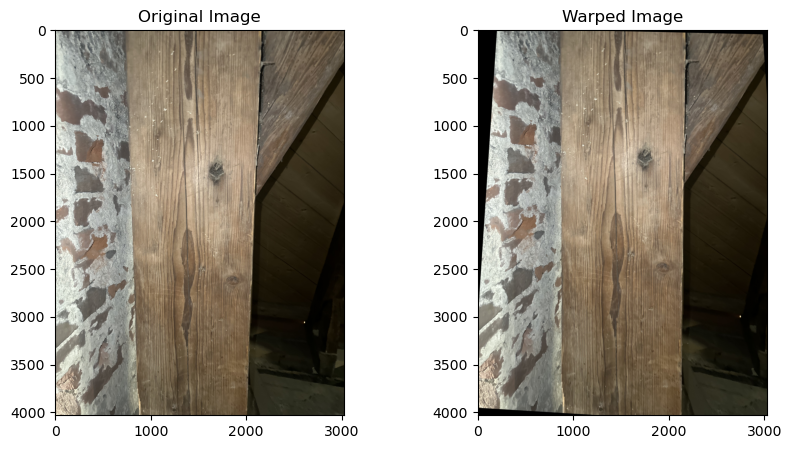

Saved warped image to warped_image.png


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_vertices(vertices):
    points = [(v[0][0], v[0][1]) for v in vertices]

    center = np.mean(points, axis=0)
    sorted_points = sorted(points, key=lambda p: (np.arctan2(p[1] - center[1], p[0] - center[0])))
    return sorted_points

def polygon_centroid(vertices):
    vertices = np.array(vertices)
    n = len(vertices)
    if n < 3:
        raise ValueError("A polygon must have at least three vertices")

    A = 0.5 * np.sum(vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1])
    Cx = (1/(6*A)) * np.sum((vertices[:-1, 0] + vertices[1:, 0]) * (vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1]))
    Cy = (1/(6*A)) * np.sum((vertices[:-1, 1] + vertices[1:, 1]) * (vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1]))

    return Cx, Cy

def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def get_vertices_from_quad(vertices, centroid, image_shape):
    dists = [
        distance(vertices[0], vertices[1]),
        distance(vertices[1], vertices[2]),
        distance(vertices[2], vertices[3]),
        distance(vertices[3], vertices[0])
    ]

    avg_length = [dists[0] + dists[2], dists[1] + dists[3]]

    rect_width = avg_length[0] / 2
    rect_height = avg_length[1] / 2
    
    # image center
    img_center_x = image_shape[1] / 2
    img_center_y = image_shape[0] / 2

    rect = np.array([
        [img_center_x - rect_width / 2, img_center_y - rect_height / 2],
        [img_center_x + rect_width / 2, img_center_y - rect_height / 2],
        [img_center_x + rect_width / 2, img_center_y + rect_height / 2],
        [img_center_x - rect_width / 2, img_center_y + rect_height / 2]
    ], dtype="float32")
    
    # Adjust rect to fit within image bounds
    rect[:, 0] = np.clip(rect[:, 0], 0, image_shape[1] - 1)
    rect[:, 1] = np.clip(rect[:, 1], 0, image_shape[0] - 1)
    
    return rect


# scale the original image
scale_factor = 0.5
image_small = cv2.resize(image_org, (0, 0), fx=scale_factor, fy=scale_factor)

# processing the vertices
vertices = preprocess_vertices(optimal_quad_pts)
centroid = polygon_centroid(vertices)

# adjust the vertices and centroid to the scaled image
vertices_small = [(v[0] * scale_factor, v[1] * scale_factor) for v in vertices]
centroid_small = (centroid[0] * scale_factor, centroid[1] * scale_factor)

# transformation matrix
rect_small = get_vertices_from_quad(vertices_small, centroid_small, image_shape=image_small.shape)
M_small = cv2.getPerspectiveTransform(np.array(vertices_small, dtype="float32"), rect_small)

# perspective transformation
output_size_small = (image_small.shape[1], image_small.shape[0])
warped_small = cv2.warpPerspective(image_small, M_small, output_size_small)

# resize the warped image to the original size
warped = cv2.resize(warped_small, (image_org.shape[1], image_org.shape[0]))

# show result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

# save the warped image
output_filename = f'warped_image.png'
cv2.imwrite(output_filename, warped)
print(f'Saved warped image to {output_filename}')

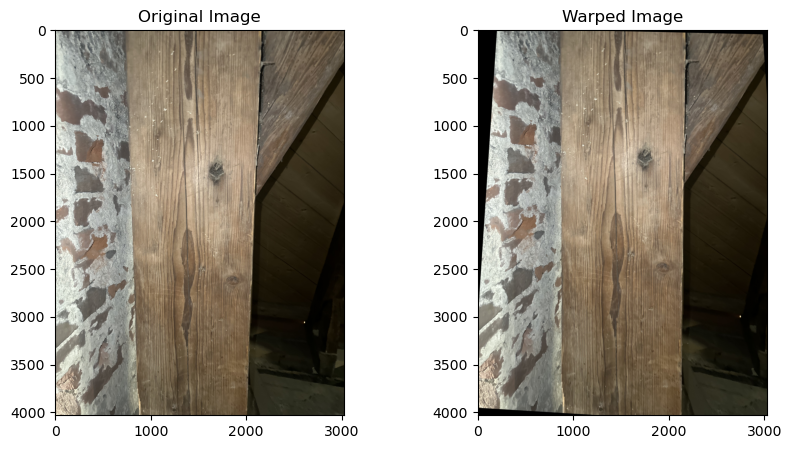

Saved warped image to large_image_wrap.jpg


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_vertices(vertices):
    points = [(v[0][0], v[0][1]) for v in vertices]

    center = np.mean(points, axis=0)
    sorted_points = sorted(points, key=lambda p: (np.arctan2(p[1] - center[1], p[0] - center[0])))
    return sorted_points

def polygon_centroid(vertices):
    vertices = np.array(vertices)
    n = len(vertices)
    if n < 3:
        raise ValueError("A polygon must have at least three vertices")

    A = 0.5 * np.sum(vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1])
    Cx = (1/(6*A)) * np.sum((vertices[:-1, 0] + vertices[1:, 0]) * (vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1]))
    Cy = (1/(6*A)) * np.sum((vertices[:-1, 1] + vertices[1:, 1]) * (vertices[:-1, 0] * vertices[1:, 1] - vertices[1:, 0] * vertices[:-1, 1]))

    return Cx, Cy

def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def get_vertices_from_quad(vertices, centroid, image_shape):
    dists = [
        distance(vertices[0], vertices[1]),
        distance(vertices[1], vertices[2]),
        distance(vertices[2], vertices[3]),
        distance(vertices[3], vertices[0])
    ]

    avg_length = [dists[0] + dists[2], dists[1] + dists[3]]

    rect_width = avg_length[0] / 2
    rect_height = avg_length[1] / 2
    
    # image center
    img_center_x = image_shape[1] / 2
    img_center_y = image_shape[0] / 2

    rect = np.array([
        [img_center_x - rect_width / 2, img_center_y - rect_height / 2],
        [img_center_x + rect_width / 2, img_center_y - rect_height / 2],
        [img_center_x + rect_width / 2, img_center_y + rect_height / 2],
        [img_center_x - rect_width / 2, img_center_y + rect_height / 2]
    ], dtype="float32")
    
    # Adjust rect to fit within image bounds
    rect[:, 0] = np.clip(rect[:, 0], 0, image_shape[1] - 1)
    rect[:, 1] = np.clip(rect[:, 1], 0, image_shape[0] - 1)
    
    return rect



# 缩放图像以减少分辨率
scale_factor = 0.5
image_small = cv2.resize(image_org, (0, 0), fx=scale_factor, fy=scale_factor)

# 预处理顶点
vertices = preprocess_vertices(optimal_quad_pts)
centroid = polygon_centroid(vertices)

# 调整顶点的坐标以匹配缩小后的图像
vertices_small = [(v[0] * scale_factor, v[1] * scale_factor) for v in vertices]
centroid_small = (centroid[0] * scale_factor, centroid[1] * scale_factor)

# 计算变换矩阵
rect_small = get_vertices_from_quad(vertices_small, centroid_small, image_shape=image_small.shape)
M_small = cv2.getPerspectiveTransform(np.array(vertices_small, dtype="float32"), rect_small)

# 进行透视变换
output_size_small = (image_small.shape[1], image_small.shape[0])
warped_small = cv2.warpPerspective(image_small, M_small, output_size_small)

# 将结果缩放回原始分辨率
warped = cv2.resize(warped_small, (image_org.shape[1], image_org.shape[0]))

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

# 保存结果图像
base_name, ext = os.path.splitext(os.path.basename(image_path))
output_filename = f'{base_name}_wrap{ext}'
cv2.imwrite(output_filename, warped)
print(f'Saved warped image to {output_filename}')